# Fully connected nn on CIFAR10
**Outline**
- torchvision Datasets
- Transforming data with Compose
- DataLoaders
- Image classification with fully connected neural networks
- Subclassing nn.Module
- torch.no_grad() context
- tranforms.Lambda

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from IPython import display

torch.manual_seed(2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
def get_params_num(net):
    return sum(map(torch.numel, net.parameters()))

    
def get_accuracy(dataloader, model, device='cpu'):
    tot = len(dataloader.dataset)
    with torch.no_grad():
        n_right = 0
        for data in dataloader:
            batch = data[0].to(device)
            labels = data[1].to(device)
            
            outputs = model(batch)
            out_labels = torch.argmax(outputs, dim=1)
            n_right += torch.sum(labels == out_labels)
    return float(n_right) / tot

Device: cuda:0


In [2]:
# import CIFAR10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


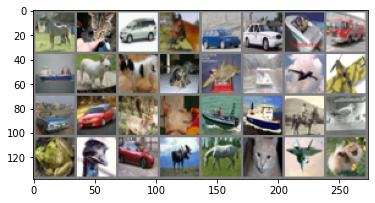

horse   cat   car horse   car   car  ship truck  ship   dog   dog   dog plane  ship plane plane   car   car  deer   dog  ship  ship horse  bird  frog  bird   car  deer horse   cat plane   dog


In [3]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))

In [4]:
print(trainset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [5]:
print("trainset.data type: {}".format(type(trainset.data)))
print("CIFAR images shape: {}".format(tuple(trainset[0][0].shape)))

trainset.data type: <class 'numpy.ndarray'>
CIFAR images shape: (3, 32, 32)


In [6]:
class FCnn(nn.Module):
    def __init__(self):
        super(FCnn, self).__init__()
        self.input_dim = 3 * 32 * 32
        self.n_classes = 10
        self.fc1 = nn.Linear(self.input_dim, 100)
        self.fc2 = nn.Linear(100, 100)
        self.out = nn.Linear(100, self.n_classes)
    
    def forward(self, x):
        x = x.view(-1, self.input_dim) # flattening
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x) # we want a raw score for the CELoss
        return x
        
net = FCnn()
net.to(device)
print("# of parameters: {}".format(get_params_num(net)))
print(net)

# of parameters: 318410
FCnn(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=10, bias=True)
)


In [7]:
net.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.0022, -0.0148, -0.0109,  ..., -0.0141, -0.0071,  0.0162],
                      [ 0.0018, -0.0075, -0.0070,  ...,  0.0143, -0.0140,  0.0162],
                      [-0.0130, -0.0174,  0.0168,  ..., -0.0079, -0.0022, -0.0165],
                      ...,
                      [-0.0018, -0.0127, -0.0152,  ...,  0.0167,  0.0014, -0.0070],
                      [ 0.0155,  0.0111,  0.0103,  ..., -0.0062, -0.0057, -0.0004],
                      [ 0.0054, -0.0154,  0.0057,  ..., -0.0120,  0.0035,  0.0134]],
                     device='cuda:0')),
             ('fc1.bias',
              tensor([-0.0076, -0.0023,  0.0023, -0.0112, -0.0176, -0.0009,  0.0054, -0.0006,
                      -0.0084,  0.0102,  0.0087,  0.0081, -0.0104, -0.0090, -0.0080,  0.0068,
                       0.0076,  0.0033,  0.0179,  0.0078, -0.0094,  0.0145, -0.0021, -0.0097,
                      -0.0138, -0.0135, -0.0114, -0.0083,  0.0157,  0.0028,  0.0047,  0.0051

In [8]:
lr = 0.001
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

In [9]:
epochs = 3

n_batches = len(trainloader)
for e in range(epochs):
    for i, data in enumerate(trainloader):
        batch = data[0].to(device)
        labels = data[1].to(device)      
        outputs = net(batch)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print("[EPOCH]: {}, [BATCH]: {}/{}, [LOSS]: {}".format(e, i, n_batches, loss.item()))
            display.clear_output(wait=True)

[EPOCH]: 2, [BATCH]: 1550/1563, [LOSS]: 1.3712530136108398


In [10]:
acc_train = get_accuracy(trainloader, net, device=device)
acc_test = get_accuracy(testloader, net, device=device)
print("Train accuracy: {}\nTest accuracy: {}".format(acc_train, acc_test))

Train accuracy: 0.47512
Test accuracy: 0.4666


### Scrambled CIFAR

In [11]:
def scramble_image(tensor, indices):
    tensor = tensor.view(-1)[indices].view(3, 32, 32)
    return tensor

indices = np.arange(3*32*32)
np.random.shuffle(indices)

In [12]:
# import CIFAR10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Lambda(lambda tens: scramble_image(tens, indices))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


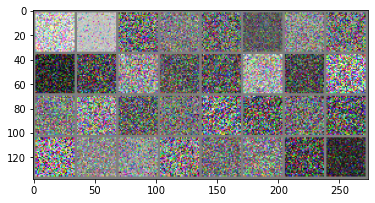

  car  deer   car horse horse  bird  deer   car truck   car horse  bird   cat plane   car  ship  deer  ship  bird  ship   cat   car  frog   dog truck  ship  frog truck  deer  ship   car  frog


In [13]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))

In [14]:
net = FCnn()
net.to(device)

lr = 0.001
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

epochs = 3

n_batches = len(trainloader)
for e in range(epochs):
    for i, data in enumerate(trainloader):
        batch = data[0].to(device)
        labels = data[1].to(device)      
        outputs = net(batch)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print("[EPOCH]: {}, [BATCH]: {}/{}, [LOSS]: {}".format(e, i, n_batches, loss.item()))
            display.clear_output(wait=True)

[EPOCH]: 2, [BATCH]: 1550/1563, [LOSS]: 1.6939338445663452


In [15]:
acc_train = get_accuracy(trainloader, net, device=device)
acc_test = get_accuracy(testloader, net, device=device)
print("Train accuracy: {}\nTest accuracy: {}".format(acc_train, acc_test))

Train accuracy: 0.48462
Test accuracy: 0.4746


## Homework
Change dataset and train you own model by subclassing nn.Module. Upload your notebook on a github repo and send me the link to francesco.cicala00@gmail.com